In [2]:
import os

os.chdir("..")

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)


Current Working Directory: c:\Users\max-s\Desktop\Uni\Master\Masterthesis\Code\git\overparametrized_dnn


In [4]:
# Import necessary modules and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.neural_nets import create_neural_1, create_neural_3, create_neural_6, parameter_tuning_nn, parameter_tuning, runs_nn
from src.knn_regression import parameter_tuning_knn, runs_knn, generate_neighbors
from src.tree_regression import parameter_tuning_tree, runs_tree
from data.data_generator import get_data, preprocess
from data.regression_functions import m1, m2, m3, m4, m5, m6, m7, m8

In [3]:
# Define a list of regression functions
regression_functions = [m1, m2, m3, m4, m5, m6, m7, m8]

## Neural Networks Regression

In [4]:
# Define a list of neural networks
neural_networks = [create_network_1, create_network_2, create_network_3]


# Define empty dataframe to store results
results_nn = pd.DataFrame(
    columns=["regression_function", "network", "units", "mses", "maes"]
)

median_and_iqr_nn = pd.DataFrame(
    columns=["regression_function", "network", "units", "mse", "iqr"]
)

# Loop through each regression function
for i, regression_func in enumerate(regression_functions):
    print(f"Regression Function {i+1}: {regression_func.__name__}")
    input_dim = regression_func.expected_dim
    x, y = get_data(regression_func, x_dim=input_dim, num_samples=1000, sigma=0.05)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    # Preprocess data
    train_data = preprocess(x_train, y_train, training=True)
    test_data = preprocess(x_test, y_test, training=False)

    # Tune networks
    units = [3, 6, 9, 12, 15]
    for j, network in enumerate(neural_networks):
        best_params = parameter_tuning_nn(
            network,
            units=units,
            train_data=train_data,
            test_data=test_data,
            input_dim=input_dim,
        )

        # Calculate regression for best units
        best_units = best_params["best_config"]
        mses, maes = runs_nn(
            network,
            units=best_units,
            input_dim=input_dim,
            regression_func=regression_func,
        )

        # Calculate median and IQR
        mse = np.median(mses)
        iqr = np.subtract(*np.percentile(mses, [75, 25]))

        # Append the results to the dataframe
        df_nn = pd.DataFrame(
            {
                "regression_function": [regression_func.__name__],
                "network": [network.__name__],
                "units": [best_units],
                "mse": [mse],
                "iqr": [iqr],
            }
        )

        mses_maes_nn = pd.DataFrame(
            {
                "regression_function": [regression_func.__name__],
                "network": [network.__name__],
                "units": [best_units],
                "mses": [mses],
                "maes": [maes],
            }
        )
        
        results_nn = pd.concat([results_nn, mses_maes_nn], ignore_index=True)
        median_and_iqr_nn = pd.concat([median_and_iqr_nn, df_nn], ignore_index=True)

        print(f"Best Units: {best_units}")
        print(f"MSE: {mse}")
        print(f"IQR: {iqr}")

    print("--------------------")

Regression Function 1: m1




Unit: 3, MSE: 1.9201120138168335, MAE: 1.31003999710083
Unit: 6, MSE: 2.0855355262756348, MAE: 1.3678287267684937
Unit: 9, MSE: 0.4425904154777527, MAE: 0.5762024521827698
Unit: 12, MSE: 1.2676810026168823, MAE: 1.0528640747070312
Unit: 15, MSE: 0.9354400038719177, MAE: 0.8927945494651794


C:\Users\max-s\AppData\Local\Temp\ipykernel_13980\3521915579.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  median_and_iqr_nn = pd.concat([median_and_iqr_nn, df_nn], ignore_index=True)


Best Units: 9
MSE: 0.5204104483127594
IQR: 0.5237486958503723
Unit: 3, MSE: 1.4984841346740723, MAE: 1.1487553119659424
Unit: 6, MSE: 0.24667738378047943, MAE: 0.43399593234062195
Unit: 9, MSE: 0.18227456510066986, MAE: 0.37972548604011536
Unit: 12, MSE: 0.24062339961528778, MAE: 0.4283997416496277
Unit: 15, MSE: 0.19609634578227997, MAE: 0.39375731348991394
Best Units: 9
MSE: 0.17045632004737854
IQR: 0.015332534909248352
Unit: 3, MSE: 2.0814108848571777, MAE: 1.3663623332977295
Unit: 6, MSE: 0.16265414655208588, MAE: 0.34849631786346436
Unit: 9, MSE: 0.18181632459163666, MAE: 0.3791104257106781
Unit: 12, MSE: 0.15222005546092987, MAE: 0.3395642042160034
Unit: 15, MSE: 0.13452009856700897, MAE: 0.32183507084846497
Best Units: 15
MSE: 0.1253003478050232
IQR: 0.088777681812644
--------------------
Regression Function 2: m2
Unit: 3, MSE: 0.31859633326530457, MAE: 0.5062429308891296
Unit: 6, MSE: 0.3085537552833557, MAE: 0.4980844557285309
Unit: 9, MSE: 0.3535829782485962, MAE: 0.531220257

In [5]:
# Define the file path
file_path = "results/"

# Save the results to a csv file
results_nn.to_csv(file_path + "nn_performance.csv", index=False)
median_and_iqr_nn.to_csv(file_path + "nn_median_iqr.csv", index=False)

## KNN-Regression

In [ ]:
# Define empty dataframe to store results
results_knn = pd.DataFrame(columns=["regression_function", "units", "mses", "maes"])
median_and_iqr_knn = pd.DataFrame(
    columns=["regression_function", "units", "mse", "iqr"]
)

# Loop through each regression function
for i, regression_func in enumerate(regression_functions):
    print(f"Regression Function {i+1}: {regression_func.__name__}")
    input_dim = regression_func.expected_dim
    x, y = get_data(regression_func, x_dim=input_dim, num_samples=1000, sigma=0.05)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    # Preprocess data
    train_data = (x_train, y_train)
    test_data = (x_test, y_test)

    # Tune number of neighbors
    units = generate_neighbors(x_train.shape[0], 25)
    best_params = parameter_tuning_knn(
        units=units,
        train_data=train_data,
        test_data=test_data,
    )

    # Calculate regression for the best number of neighbors
    best_units = best_params["best_config"]
    mses, maes = runs_knn(
        unit=best_units,
        input_dim=input_dim,
        regression_func=regression_func,
    )

    mse = np.median(mses)
    iqr = np.subtract(*np.percentile(mses, [75, 25]))

    # Append the results to the dataframe
    df_knn = pd.DataFrame(
        {
            "regression_function": [regression_func.__name__],
            "units": [best_units],
            "mse": [mse],
            "iqr": [iqr],
        }
    )

    mses_maes_knn = pd.DataFrame(
        {
            "regression_function": [regression_func.__name__],
            "units": [best_units],
            "mses": [mses],
            "maes": [maes],
        }
    )

    median_and_iqr_knn = pd.concat([median_and_iqr_knn, df_knn], ignore_index=True)
    results_knn = pd.concat([results_knn, mses_maes_knn], ignore_index=True)

    print(f"Best Units: {best_units}")
    print(f"MSE: {mse}")
    print(f"IQR: {iqr}")

    print("--------------------")

In [6]:
# Define the file path
file_path = "results/knn_performance.csv"

# Save the results to a csv file
results_knn.to_csv(file_path, index=False)

## Tree Regression

In [ ]:
# Define empty dataframe to store results
results_tree = pd.DataFrame(columns=["regression_function", "max_depth", "max_leaf_nodes", "mses", "maes"])
median_and_iqr_tree = pd.DataFrame(
    columns=["regression_function", "max_depth", "max_leaf_nodes", "mse", "iqr"]
)

# Loop through each regression function
for i, regression_func in enumerate(regression_functions):
    print(f"Regression Function {i+1}: {regression_func.__name__}")
    input_dim = regression_func.expected_dim
    x_train, y_train = get_data(regression_func, x_dim=input_dim, num_samples=800, sigma=0.05)

    # Preprocess data
    train_data = (x_train, y_train)

    # Tune number of leafs an depth
    best_params = parameter_tuning_tree(
        train_data=train_data,
    )

    max_depth = best_params["max_depth"]
    max_leaf_nodes = best_params["max_leaf_nodes"]

    # Calculate regression for the best number of neighbors
    mses, maes = runs_tree(
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        input_dim=input_dim,
        regression_func=regression_func,
    )

    mse = np.median(mses)
    iqr = np.subtract(*np.percentile(mses, [75, 25]))

    # Append the results to the dataframe
    df_tree = pd.DataFrame(
        {
            "regression_function": [regression_func.__name__],
            "max_depth": max_depth,
            "max_leaf_nodes": max_leaf_nodes,
            "mse": [mse],
            "iqr": [iqr],
        }
    )

    mses_maes_tree = pd.DataFrame(
        {
            "regression_function": [regression_func.__name__],
            "max_depth": max_depth,
            "max_leaf_nodes": max_leaf_nodes,
            "mses": [mses],
            "maes": [maes],
        }
    )

    median_and_iqr_tree = pd.concat([median_and_iqr_tree, df_tree], ignore_index=True)
    results_tree = pd.concat([results_tree, mses_maes_tree], ignore_index=True)

    print(f"max_depth: {max_depth}")
    print(f"max_leaf_nodes: {max_leaf_nodes}")
    print(f"MSE: {mse}")
    print(f"IQR: {iqr}")

    print("--------------------")

In [28]:
# Load dataframes from results folder
nn_performance = pd.read_csv("results/nn_performance.csv")
knn_performance = pd.read_csv("results/knn_performance.csv")
tree_performance = pd.read_csv("results/tree_performance.csv")

# Filter for networks
nn_1_performance = nn_performance[nn_performance["network"] == "create_network_1"]
nn_2_performance = nn_performance[nn_performance["network"] == "create_network_2"]
nn_3_performance = nn_performance[nn_performance["network"] == "create_network_3"] 

In [29]:
# Get the "mses" column from each dataframe
nn_1_mses = nn_1_performance.loc[nn_1_performance["regression_function"] == "m1", "mses"]
nn_2_mses = nn_2_performance.loc[nn_2_performance["regression_function"] == "m1", "mses"]
nn_3_mses = nn_3_performance.loc[nn_3_performance["regression_function"] == "m1", "mses"]
knn_mses = knn_performance.loc[knn_performance["regression_function"] == "m1", "mses"]
tree_mses = tree_performance.loc[tree_performance["regression_function"] == "m1","mses"]


In [30]:
import json

# Convert 'mses' and 'maes' columns to lists of numbers
def convert_to_list(df):
    df.loc[:, 'mses'] = df['mses'].apply(json.loads).apply(lambda x: [float(i) for i in x])
    df.loc[:, 'maes'] = df['maes'].apply(json.loads).apply(lambda x: [float(i) for i in x])
    return df

nn_1_performance = convert_to_list(nn_1_performance)
nn_2_performance = convert_to_list(nn_2_performance)
nn_3_performance = convert_to_list(nn_3_performance)
knn_performance = convert_to_list(knn_performance)
tree_performance = convert_to_list(tree_performance)

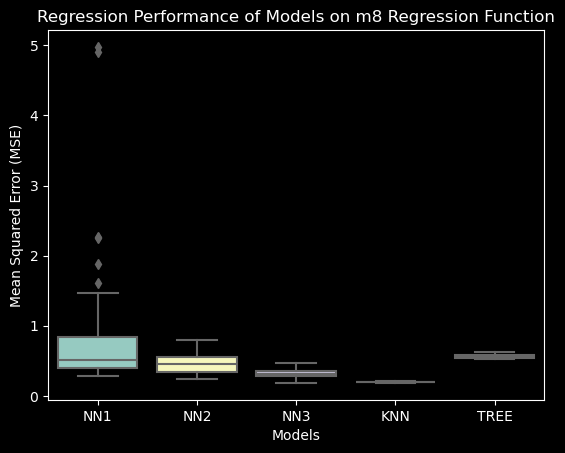

In [41]:
import seaborn as sns
import pandas as pd

def plot_boxplot(regression_func):
    regression_func = str(regression_func)

    NN1 = nn_1_performance.loc[nn_1_performance["regression_function"] == regression_func, "mses"].values[0]
    NN2 = nn_2_performance.loc[nn_2_performance["regression_function"] == regression_func, "mses"].values[0]
    NN3 = nn_3_performance.loc[nn_3_performance["regression_function"] == regression_func, "mses"].values[0]
    KNN = knn_performance.loc[knn_performance["regression_function"] == regression_func, "mses"].values[0]
    TREE = tree_performance.loc[tree_performance["regression_function"] == regression_func, "mses"].values[0]

    df = pd.DataFrame({'NN1': NN1, 'NN2': NN2, 'NN3': NN3, 'KNN': KNN, 'TREE': TREE})

    sns.boxplot(data=df)

    # Add labels and title
    plt.xlabel('Models')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Regression Performance of Models on {} Regression Function'.format(regression_func))

    plt.show()

plot_boxplot('m8')
